Digite o nó que enviará a sonda em G: 
Matriz de Sondas Isis =  [[1, 5, 3], [2, 6, 4], [7]] 

Abilene Edges =  [(0, 1), (0, 2), (1, 10), (2, 9), (10, 7), (9, 8), (7, 6), (8, 5), (3, 6), (6, 4)]
Matriz de Sondas Abilene  = [[1, 0, 2, 9, 8, 5], [10, 7, 6, 3], [4]]

GEANT Edges =  [(0, 1), (0, 2), (0, 4), (0, 34), (0, 30), (1, 33), (2, 32), (2, 35), (2, 38), (2, 36), (2, 31), (4, 3), (4, 5), (4, 6), (4, 8), (4, 16), (4, 17), (4, 29), (34, 7), (34, 24), (30, 39), (36, 37), (3, 10), (3, 19), (5, 23), (8, 9), (8, 25), (29, 15), (29, 28), (23, 22), (9, 18), (15, 12), (28, 27), (22, 13), (22, 26), (12, 20), (12, 14), (11, 13), (21, 27)]
Matriz de Sondas GEANT  = [[1, 0, 2, 32], [35], [38], [36, 37], [31], [4, 3, 10], [19], [5, 23, 22, 13, 11], [26], [6], [8, 9, 18], [25], [16], [17], [29, 15, 12, 20], [14], [28, 27, 21], [34, 7], [24], [30, 39], [33]]

GridNet Edges =  [(0, 8), (0, 2), (0, 3), (0, 7), (8, 6), (2, 1), (3, 4), (7, 5)]
Matriz de Sondas GridNet  = [[1], [2, 0, 8, 6], [3, 4], [7, 5

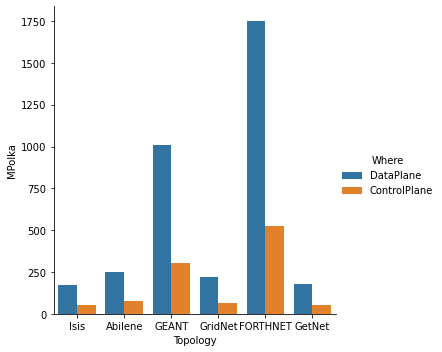

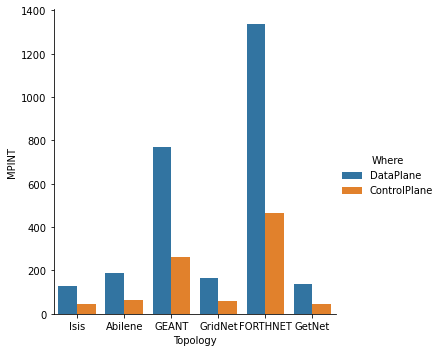

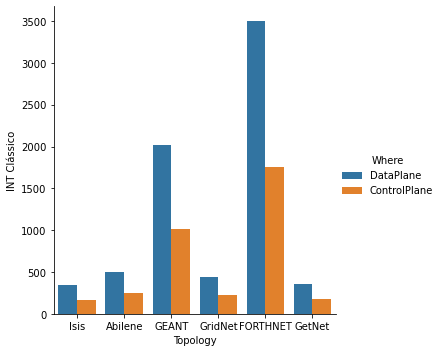

In [8]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import glob

GIsis = nx.from_edgelist([[1,5],[5,3],[1,2],[2,6],[6,4],[6,7]])
#GIsis = nx.from_edgelist([[0, 1], [0, 2], [1, 10], [2, 9], [10, 7], [9, 8], [3, 6], [4, 6], [6, 7], [5, 8]])
sonda = []
sondaTemp = []

def EdgeListToMST(path):
    edgeList = readTopology(path)
    #print(edgeList)
    G = nx.from_edgelist(edgeList)
    T = nx.minimum_spanning_tree(G,algorithm='prim')
    #print(T)
    return T

def GMLToMST(path):
    G = nx.read_gml(path,destringizer=int,label='id') #
    topologyName = G.graph['Network'] #Hooka o atributo network que identifica o nome da Topologia
    edgeList = list(map(list,G.edges()))
    #print(edgeList)
    G = nx.from_edgelist(edgeList)
    T = nx.minimum_spanning_tree(G,algorithm='prim')
    edgeList = list(map(list, T.edges()))
    T = nx.from_edgelist(edgeList)
    #print(T)
    return T,topologyName


def toDataframe(df,topology,sonda):
    #Overhead por abordagem
    overheadDP_mPolka = 0
    overheadDP_mPINT = 0
    overheadDP_INTClassico = 0
    overheadCP_mPolka = 0
    overheadCP_mPINT = 0
    overheadCP_INTClassico = 0

    for i in range(len(sonda)):
        overheadDP_mPolka += mPolkaDP_fixoPSonda + mPolkaDP_fixoPNo*len(sonda[i])
        overheadDP_mPINT += mPINTDP_fixoPSonda + mPINTDP_fixoPNo*len(sonda[i])
        overheadDP_INTClassico += INTClassicoDP_fixoPSonda + INTClassicoDP_fixoPNo*len(sonda[i])

        overheadCP_mPolka += mPolkaCP_fixoPSonda + mPolkaCP_fixoPNo*len(sonda[i])
        overheadCP_mPINT += mPINTCP_fixoPSonda + mPINTCP_fixoPNo*len(sonda[i])
        overheadCP_INTClassico += INTClassicoCP_fixoPSonda + INTClassicoCP_fixoPNo*len(sonda[i])

    #print('Overhead DataPlane MPolka = ',overheadDP_mPolka)
    #print('Overhead DataPlane MPINT = ',overheadDP_mPINT)
    #print('Overhead DataPlane INT Clássico = ',overheadDP_INTClassico)
    #print('Overhead ControlPlane MPolka = ',overheadCP_mPolka)
    #print('Overhead ControlPlane MPINT = ',overheadCP_mPINT)
    #print('Overhead ControlPlane INT Clássico = ',overheadCP_INTClassico)

    matrixOverhead = {}
    matrixOverhead['Topology'] = [topology,topology]
    matrixOverhead['Where'] = ['DataPlane','ControlPlane']
    matrixOverhead['MPolka'] = [overheadDP_mPolka,overheadCP_mPolka]
    matrixOverhead['MPINT'] = [overheadDP_mPINT,overheadCP_mPINT]
    matrixOverhead['INT Clássico'] = [overheadDP_INTClassico,overheadCP_INTClassico]
    df2 = pd.DataFrame(data=matrixOverhead)
    result = pd.concat([df,df2],ignore_index=True)
    return result

def appendGraphToDataFrame(df,path):
    G,topologyName = GMLToMST(path)
    print(topologyName,'Edges = ', G.edges())
    sonda.clear()
    sondaAbilene = dfs(G,node,visited=[False] * (G.number_of_nodes() + 1))
    print('Matriz de Sondas',topologyName,' =',sondaAbilene)
    print()
    df = toDataframe(df,topologyName,sondaAbilene)
    return df

def appendAllTopologysToDataFrame(df):
    listTopology = glob.glob('topologyZoo/*.gml')
    for topology in listTopology:
        df = appendGraphToDataFrame(df,topology)
    return df

def readTopology(path):
    edgeList = []

    with open(path,'r') as arq:
        lines = arq.readlines()
    
    for i in range(len(lines)):
        line = lines[i].split(' ')
        line.pop()
        line = list(map(int,line))
        edgeList.append(line)
        #print(line)
    
    return edgeList

def dfs(G,v,visited): #Retorna a matriz de sondas do MPolka
  sondaTemp.append(v)
  visited[v] = True
  for w in G.neighbors(v):
    if len(list(G.neighbors(v))) == 1: #DEADEND
        #print(sondaTemp)
        sonda.append(sondaTemp.copy())
        sondaTemp.clear()
    if not visited[w]:
        dfs(G,w,visited)
  return sonda

print('Digite o nó que enviará a sonda em G: ')
node = int(input())


mPolkaDP_fixoPSonda = 10
mPolkaDP_fixoPNo = 20
mPolkaCP_fixoPSonda = 3
mPolkaCP_fixoPNo = 6

mPINTDP_fixoPSonda = 8
mPINTDP_fixoPNo = 15
mPINTCP_fixoPSonda = 3
mPINTCP_fixoPNo = 5

INTClassicoDP_fixoPSonda = 20
INTClassicoDP_fixoPNo = 40
INTClassicoCP_fixoPSonda = 10
INTClassicoCP_fixoPNo = 20

df = pd.DataFrame(columns=['Topology','Where','MPolka','MPINT','INT Clássico']) #Empty Row Dataframe

sondaIsis = dfs(GIsis,node,[False] * (GIsis.number_of_nodes() + 1))
print('Matriz de Sondas Isis = ',sondaIsis,'\n')
df = toDataframe(df,'Isis',sondaIsis) #DataFrame Isis Example


df = appendAllTopologysToDataFrame(df)
print(df)
df.to_csv('overhead.csv',index=False)

#sns.displot(df, x="MPolka",hue="Where",element="step");
sns.catplot(x="Topology", y="MPolka", hue="Where",kind="bar", data=df, errorbar = None);
sns.catplot(x="Topology", y="MPINT", hue="Where",kind="bar", data=df, errorbar = None);
sns.catplot(x="Topology", y="INT Clássico", hue="Where",kind="bar", data=df, errorbar = None);
